In [244]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.pipeline import Pipeline

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

from gensim.parsing.preprocessing import remove_stopwords, strip_multiple_whitespaces, strip_non_alphanum, strip_punctuation
from gensim.models.phrases import Phrases, Phraser

from fuzzywuzzy import process

from tqdm import tqdm_notebook

from wordcloud import WordCloud

from IPython.display import HTML

In [91]:
df = pd.read_csv(f"{os.getcwd()}/data/old/processed/matched_common_labels.csv", index_col=0)

So we process the labels using gensim to give us something to cluster with

In [92]:
def label_cleaning(labels):
    
    processed_labels = [remove_stopwords(label) for label in labels]
    processed_labels = [strip_non_alphanum(label) for label in processed_labels]
    processed_labels = [strip_punctuation(label) for label in processed_labels]
    processed_labels = [strip_multiple_whitespaces(label) for label in processed_labels]
    
    return processed_labels

In [93]:
def make_bigrams(labels):
    
    label_word_list = [label.split(" ") for label in labels]
    phrases = Phrases(label_word_list, 
                      min_count=2,
                     threshold=3)

    bigram_maker = Phraser(phrases)
    
    
    bigram_lst = [gram for gram in bigram_maker[label_word_list]]
    
    bigrams = [" ".join(list(it.chain(bigram))) 
               for bigram in bigram_lst]
    
    return bigrams
    

In [94]:
df["clean_labels"] = label_cleaning(df.index.to_list())

In [95]:
df["bigram_labels"] = make_bigrams(df.clean_labels.to_list())

In [96]:
df

,file_name,number_of_files,ratio_of_files,number_of_files_rare,number_of_files_new,ratio_of_files_new,clean_labels,bigram_labels
label,,,,,,,,
accruals and deferred income,['07314921_2018-06-21' '05305200_2018-11-27' '...,31,0.061265,1,32,0.063241,accruals deferred income,accruals deferred income
amounts falling due after more than one year,['05549284_2018-04-05' '01246756_2018-12-28' '...,12,0.023715,8,20,0.039526,amounts falling year,amounts_falling year
amounts falling due within one year,['02723119_2018-07-10' '07987664_2018-11-22' '...,64,0.126482,4,68,0.134387,amounts falling year,amounts_falling year
called up share capital,['04578942_2018-09-10' '10339765_2018-05-21' '...,229,0.452569,17,246,0.486166,called share capital,called share capital
capital and reserves,['09946357_2018-10-11' '04210567_2018-06-13' '...,58,0.114625,3,61,0.120553,capital reserves,capital reserves
capital redemption reserve,['02736280_2018-01-18' '01581154_2018-07-24' '...,9,0.017787,1,10,0.019763,capital redemption reserve,capital redemption reserve
cash and cash equivalents,['00851110_2018-10-07' '07427985_2018-08-22' '...,8,0.015810,5,13,0.025692,cash cash equivalents,cash cash equivalents
cash at bank,['08804092_2018-08-15' '01557781_2019-01-24' '...,31,0.061265,2,33,0.065217,cash bank,cash_bank
cash at bank and in hand,['06757157_2018-08-15' '04578942_2018-09-10' '...,188,0.371542,7,195,0.385375,cash bank hand,cash_bank hand


OK, so lets build a couple of pipelines in sklearn to process the data

In [111]:
tfidf_dim_reduc_pipe = Pipeline([
                                 ("tf-idf", TfidfVectorizer()),
                                 ("svd", TruncatedSVD(n_components=50)),
                                 ("t-sne",  TSNE(n_components=2))
                                ])

first the raw labels

In [112]:
X = tfidf_dim_reduc_pipe.fit_transform(df.index.to_list())

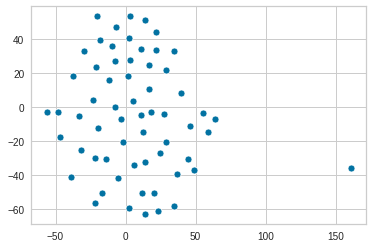

In [113]:
sns.scatterplot(X[:,0], X[:,1])

ok, there doesn't look like much structure to that data, apart from like that one point over there, we can try with the cleaned labels, apart from like that one point over there

In [114]:
X_cleaned = tfidf_dim_reduc_pipe.fit_transform(df.clean_labels.to_list())

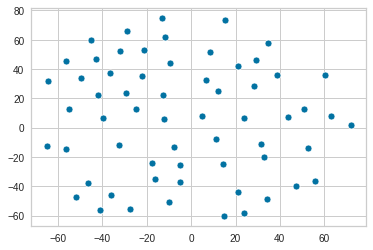

In [115]:
sns.scatterplot(X_cleaned[:,0], X_cleaned[:,1])

not that structured either, but that mad point has gone. Shows the benifit of cleaned data i guess. Maybe a little more structure if you squint? idk. Try with the bigrams

In [116]:
X_bigram_cleaned = tfidf_dim_reduc_pipe.fit_transform(df.bigram_labels.to_list())

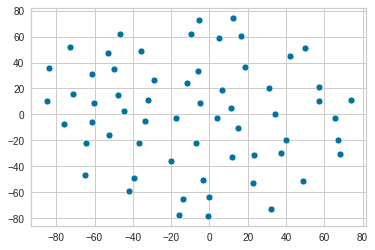

In [117]:
sns.scatterplot(X_bigram_cleaned [:,0], X_bigram_cleaned [:,1])

a bit more cluster-y again? still looks quite homogenous. Lets give our clustering a go with the bi-grams as that might give us somethign.

In [281]:
elbow_plot = KElbowVisualizer(KMeans(), k=(2,12), random_state=42)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7307ceb0f0>,
                 k=None, metric=None, model=None, timings=True)

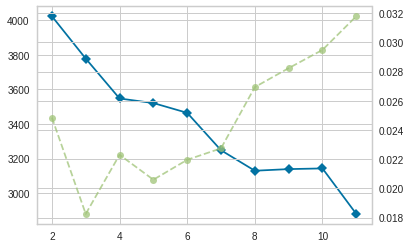

In [282]:
elbow_plot.fit(X_bigram_cleaned)

There is'nt really much here, maybe 4? 

In [283]:
kmeans_mdl = KMeans(n_clusters = 4, random_state=42)

In [284]:
kmeans_labels = kmeans_mdl.fit_predict(X_bigram_cleaned)

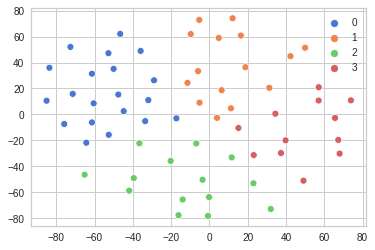

In [285]:
sns.scatterplot(x=X_bigram_cleaned[:,0],
                y=X_bigram_cleaned[:,1], 
                hue = kmeans_labels , 
                legend="full",
                palette =sns.color_palette("muted",
                                           n_colors=np.unique(kmeans_labels).size
                                          ))

Count vectorisation anyone?

In [144]:
cv_dim_reduc_pipe = Pipeline([
                                 ("tf-idf", CountVectorizer()),
                                 ("svd", TruncatedSVD(n_components=50)),
                                 ("t-sne",  TSNE(n_components=2))
                                ])

first the raw labels

In [145]:
X_cv = cv_dim_reduc_pipe.fit_transform(df.index.to_list())

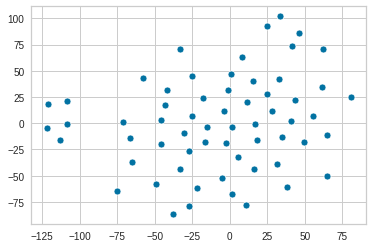

In [146]:
sns.scatterplot(X_cv[:,0], X_cv[:,1])

well, that looks like at least two clusters

In [147]:
X_cv_cleaned = cv_dim_reduc_pipe.fit_transform(df.clean_labels.to_list())

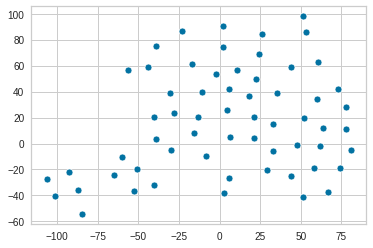

In [148]:
sns.scatterplot(X_cv_cleaned[:,0], X_cv_cleaned[:,1])

Looks like more structure here, but not a huge amount...

In [149]:
X_cv_bigram_cleaned = cv_dim_reduc_pipe.fit_transform(df.bigram_labels.to_list())

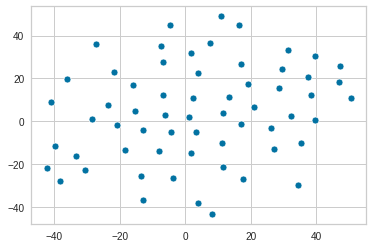

In [151]:
sns.scatterplot(X_cv_bigram_cleaned [:,0], X_cv_bigram_cleaned [:,1])

a bit more again? I know I might be clutching at straws here

In [335]:
elbow_plot =KElbowVisualizer(KMeans(random_state=42), k=(2,15), timings=False)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7307c0cd30>,
                 k=None, metric=None, model=None, timings=False)

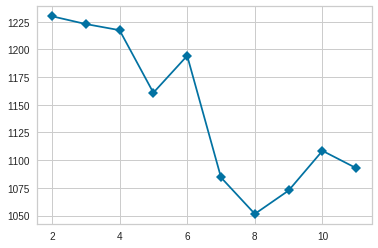

In [287]:
elbow_plot.fit(X_cv_bigram_cleaned)

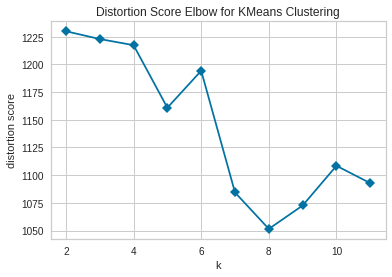

In [310]:
elbow_fig = elbow_plot.fit(X_cv_bigram_cleaned).poof(outpath=f"{os.getcwd()}/data/old/processed/elbow_plot.png")

In [306]:
elbow_plot.fit(X_cv_bigram_cleaned).savefig(f"{os.getcwd()}/data/old/processed/elbow_plot.png")

AttributeError: 'KMeans' object has no attribute 'savefig'

8 it looks like!

In [290]:
kmeans_mdl = KMeans(n_clusters = 8, random_state=42)

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7307b10208>,
                     model=None)

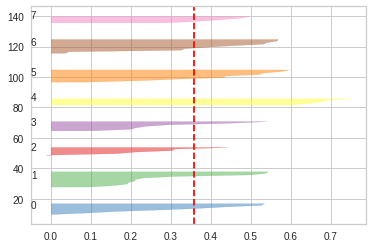

In [291]:
visualizer = SilhouetteVisualizer(kmeans_mdl)
visualizer.fit(X_cv_bigram_cleaned)

In [292]:
kmeans_cv_labels = kmeans_mdl.fit_predict(X_cv_bigram_cleaned)

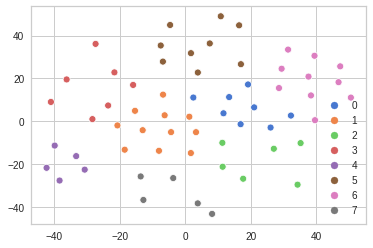

In [311]:
f=sns.scatterplot(x=X_cv_bigram_cleaned[:,0],
                y=X_cv_bigram_cleaned[:,1], 
                hue = kmeans_cv_labels , 
                legend="full",
                palette =sns.color_palette("muted",
                                           n_colors=np.unique(kmeans_cv_labels).size
                                          ))

In [315]:
cluster_scatter = f.get_figure()

cluster_scatter.savefig(f"{os.getcwd()}/data/old/processed/cluster_scatter_plot.png")

Let's have a look and see what is in each group

In [294]:
df["kmeans_cv_clusters"] = kmeans_cv_labels



In [327]:
HTML(df[["bigram_labels",
         "kmeans_cv_clusters", 
        ]].sort_values("kmeans_cv_clusters").to_html())

,bigram_labels,kmeans_cv_clusters
label,,
net current assets liabilities,net_current assets liabilities,0
total liabilities,total liabilities,0
liabilities,liabilities,0
share capital,share capital,0
net current liabilities,net_current liabilities,0
provisions for liabilities,provisions liabilities,0
net liabilities,net liabilities,0
current liabilities,current liabilities,0
investments,investments,1


In [201]:
def create_cloud(df, group):
    group_text = " ".join(df[df["kmeans_cv_clusters"]==group].clean_labels.to_list())
    return WordCloud().generate(group_text)

In [320]:
cloud_lst = [create_cloud(df, cluster) for cluster in df.sort_values("kmeans_cv_clusters").kmeans_cv_clusters.unique().tolist()]

In [325]:
df.kmeans_cv_clusters.unique().tolist()

[3, 4, 7, 2, 1, 6, 0, 5]

show the word clouds

In [298]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

cluster: 0


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 1


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 2


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 3


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 4


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 5


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 6


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

cluster: 7


<Figure size 432x288 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

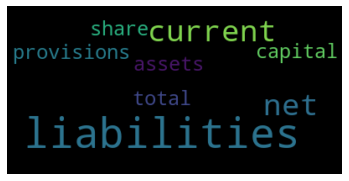

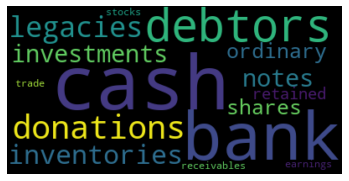

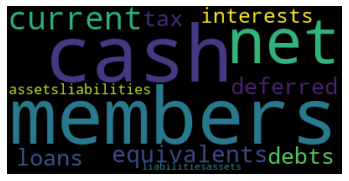

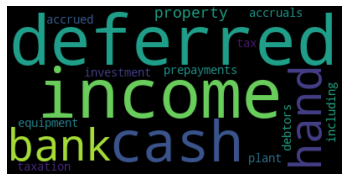

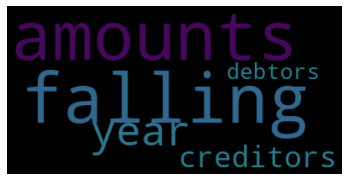

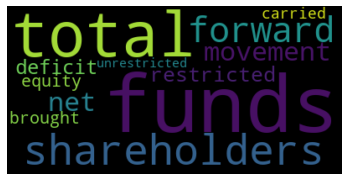

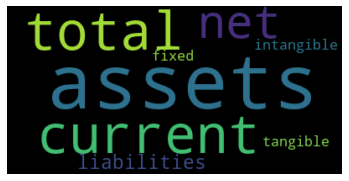

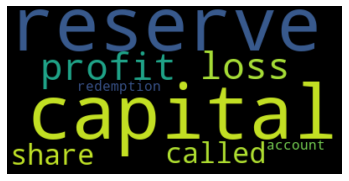

In [331]:
cloud_lst = []
for cluster in df.sort_values("kmeans_cv_clusters").kmeans_cv_clusters.unique().tolist():
    print(f"cluster: {cluster}")
    plt.figure()
    cloud_lst.append(create_cloud(df, cluster))
    plt.imshow(cloud_lst[-1], interpolation='bilinear')
    plt.axis("off")